# Data exploration
In this section, we will explore which features of the dataset contribute to the car's price.

In [3]:
# Import libraries

import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
import seaborn as sb

In [4]:
# Set data directory

data_dir = 'data'

In [33]:
!unzip craigslist-carstrucks-data.zip -d $data_dir

Archive:  craigslist-carstrucks-data.zip
  inflating: data/vehicles.csv       


In [34]:
# Read in data

data = pd.read_csv(os.path.join(data_dir, 'vehicles.csv'))

data.head()

,id,url,region,region_url,price,year,manufacturer,model,condition,cylinders,...,drive,size,type,paint_color,image_url,description,county,state,lat,long
0,7034441763,https://saltlakecity.craigslist.org/cto/d/salt...,salt lake city,https://saltlakecity.craigslist.org,17899,2012.0,volkswagen,golf r,excellent,4 cylinders,...,4wd,compact,hatchback,black,https://images.craigslist.org/00G0G_fTLDWM5Xyv...,PRICE REDUCED! -Garage kept -Low Miles (63K)...,NaN,ut,40.7372,-111.858
1,7034440610,https://saltlakecity.craigslist.org/ctd/d/sand...,salt lake city,https://saltlakecity.craigslist.org,0,2016.0,ford,f-150,excellent,NaN,...,4wd,NaN,NaN,NaN,https://images.craigslist.org/00v0v_7Cu0buIofU...,Drive it home today. Call (Or Text) us now !!C...,NaN,ut,40.5881,-111.884
2,7034440588,https://saltlakecity.craigslist.org/ctd/d/sand...,salt lake city,https://saltlakecity.craigslist.org,46463,2015.0,gmc,sierra 1500,excellent,NaN,...,4wd,NaN,NaN,white,https://images.craigslist.org/01515_lPvJ9bfbdY...,Drive it home today. Call (Or Text) us now !!C...,NaN,ut,40.5881,-111.884
3,7034440546,https://saltlakecity.craigslist.org/ctd/d/sand...,salt lake city,https://saltlakecity.craigslist.org,0,2016.0,ford,f-150,excellent,NaN,...,4wd,NaN,NaN,NaN,https://images.craigslist.org/00T0T_6Rjfp3NS4O...,Drive it home today. Call (Or Text) us now !!C...,NaN,ut,40.5881,-111.884
4,7034406932,https://saltlakecity.craigslist.org/ctd/d/evan...,salt lake city,https://saltlakecity.craigslist.org,49999,2018.0,ford,f-450,NaN,NaN,...,4wd,NaN,pickup,white,https://images.craigslist.org/00W0W_8yIUwRBXXd...,2018 Ford F-350 F350 F 350 SD Lariat Crew Cab ...,NaN,ut,40.3744,-104.694


## Data clean-up
Drop rows whose year and price values are zero ornull. We will also drop columns that we will not be using for exploration.

In [35]:
df = data[data['price'] != 0]
df = df.dropna(subset=['year', 'manufacturer', 'model'])

df = df.drop(columns=['id', 'url', 'region', 'region_url', 'title_status', 'vin',
                      'image_url', 'description', 'county', 'lat', 'long', 'state', 
                      'cylinders'])

df.head()

,price,year,manufacturer,model,condition,cylinders,fuel,odometer,transmission,drive,size,type,paint_color
0,17899,2012.0,volkswagen,golf r,excellent,4 cylinders,gas,63500.0,manual,4wd,compact,hatchback,black
2,46463,2015.0,gmc,sierra 1500,excellent,NaN,gas,7554.0,automatic,4wd,NaN,NaN,white
4,49999,2018.0,ford,f-450,NaN,NaN,diesel,70150.0,automatic,4wd,NaN,pickup,white
6,34500,2017.0,ford,f-350,NaN,NaN,diesel,95484.0,automatic,4wd,NaN,pickup,white
7,14500,2007.0,gmc,sierra,NaN,NaN,gas,89340.0,automatic,4wd,NaN,pickup,NaN


### Data filtering
Take only the entries that were posted from 2015 to 2019 and plot the distribution of data to within these years.

In [36]:
years = [2015, 2016, 2017, 2018, 2019]

df = df[df['year'].isin(years)]

df = df.drop(columns=['year'])

df.head()

,price,year,manufacturer,model,condition,cylinders,fuel,odometer,transmission,drive,size,type,paint_color
2,46463,2015.0,gmc,sierra 1500,excellent,NaN,gas,7554.0,automatic,4wd,NaN,NaN,white
4,49999,2018.0,ford,f-450,NaN,NaN,diesel,70150.0,automatic,4wd,NaN,pickup,white
6,34500,2017.0,ford,f-350,NaN,NaN,diesel,95484.0,automatic,4wd,NaN,pickup,white
13,27999,2015.0,gmc,sierra,NaN,NaN,gas,73612.0,automatic,4wd,NaN,pickup,brown
16,35500,2015.0,gmc,sierra,NaN,NaN,diesel,127515.0,automatic,4wd,NaN,pickup,black


Save filtered dataset in case we need to load it in again in the future.

In [37]:
df.to_csv(os.path.join(data_dir, 'vehicles_filtered.csv'), index=False)

In [38]:
df = pd.read_csv(os.path.join(data_dir, 'vehicles_filtered.csv'))

122655


Text(0.5, 1.0, 'Entries per year')

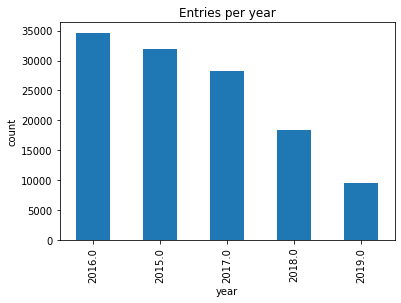

In [39]:
print(df.shape[0])
df['year'].value_counts().plot(kind='bar')
plt.xlabel('year')
plt.ylabel('count')
plt.title('Entries per year')

### Car model feature
The model feature requires additional clean-up. This is because unlike other features, the model column's exact text value can vary greatly depending on the poster's prerogative. For example, a car's actual model can ba 'civic' but the poster might opt to put in 'civic automatic' instead which is essentially the same category but, if unhandled, will result to its own separate category. This can be seen by simply viewing the raw model feature values.

In [40]:
df['model'].value_counts()

f-150                        3128
1500                         2548
silverado 1500               2201
2500                         1355
altima                       1351
                             ... 
xc70 t6 platinum                1
mkz 4dr sdn awd                 1
f-250 xlt crew diesel 4x4       1
tiguan sel 4motion              1
model x 90                      1
Name: model, Length: 8897, dtype: int64

In [41]:
model_counts = df['model'].value_counts()

model_counts = model_counts[model_counts < 50] # Estimate to show redundant categories

model_counts

tucson se sport utility      49
focus se hatchback 4d        49
patriot sport                49
outback 2.5i limited         49
expedition max               48
                             ..
xc70 t6 platinum              1
mkz 4dr sdn awd               1
f-250 xlt crew diesel 4x4     1
tiguan sel 4motion            1
model x 90                    1
Name: model, Length: 8535, dtype: int64

Use containtment to normalize redundant model classes

In [42]:
import re
from sklearn.feature_extraction.text import CountVectorizer

token_pattern = r'(?!19|20\d{2})\b[a-zA-Z0-9-.]+'

def calculate_containment(answer, source, n):    
    match = re.search(token_pattern, source)
    
    if not match:
        return 0
    
    counts = CountVectorizer(ngram_range=(1,n),
                             token_pattern=token_pattern) # Exclude year in model
    
    ngram_array = counts.fit_transform([answer, source]).toarray()
    
    intersections = [min(c, ngram_array[1][i]) for i, c in enumerate(ngram_array[0])]
    
    source_sum = np.sum(ngram_array[0])
    
    containment = np.sum(intersections) / np.sum(ngram_array[0]) if source_sum > 0 else 0
    
    return containment

In [43]:
def clean_model_feature(df_to_clean):    
    # Account for '-' only filler for model feature value
    df_to_clean[df_to_clean['model'] == '-'] = np.nan
    
    df_to_clean.dropna(subset=['model'], inplace=True)
    
    model_word_count = []
    
    for i in range(len(df_to_clean)):
        model = df_to_clean.iloc[i]['model']
        model_word_count.append(len(model.split()))
    
    df_to_clean['model_word_count'] = model_word_count
    
    df_to_clean.sort_values(by='model_word_count', inplace=True)
    
    model_manufacturer_classes = {}
    
    print_every = 10000
    
    df_len = len(df_to_clean)
    
    new_models = []
    
    for i in range(df_len):
        if i % print_every == 0:
            print('Processing row {}/{}'.format(i + 1, df_len))
            
        if df_to_clean.iloc[i]['model_word_count'] < 1:
            new_models.append('')
            
            continue
        
        model = df_to_clean.iloc[i]['model'].lower().replace('-', '')
        
        manufacturer = df_to_clean.iloc[i]['manufacturer']
        
        if manufacturer not in model_manufacturer_classes:
            model_manufacturer_classes[manufacturer] = []
            
        model_classes = model_manufacturer_classes[manufacturer]
        
        match_model_class = None
        
        for model_class in model_classes:
            if model == model_class:
                match_model_class = model
                break
            
            model_class_len = len(model_class.split())
            
            containment = calculate_containment(model, model_class, model_class_len)
            
            model_len = len(re.findall(token_pattern, model))
            
            if model_len == 0:
                continue
            
            if containment >= model_class_len / model_len:
                match_model_class = model_class
                break
                
        if match_model_class is None:
            match_model_class = model
            model_classes.append(model)
        
        new_models.append(match_model_class)
        
    df_to_clean['model'] = new_models

In [44]:
clean_model_df = df.copy()

clean_model_feature(clean_model_df)

clean_model_df = clean_model_df.drop(columns=['model_word_count'])

clean_model_df

Processing row 1/122654
Processing row 10001/122654
Processing row 20001/122654
Processing row 30001/122654
Processing row 40001/122654
Processing row 50001/122654
Processing row 60001/122654
Processing row 70001/122654
Processing row 80001/122654
Processing row 90001/122654
Processing row 100001/122654
Processing row 110001/122654
Processing row 120001/122654


,price,year,manufacturer,model,condition,cylinders,fuel,odometer,transmission,drive,size,type,paint_color
122654,24895.0,2019.0,jeep,cherokee,NaN,4 cylinders,gas,6973.0,automatic,4wd,NaN,SUV,white
46157,12999.0,2016.0,nissan,altima,NaN,NaN,gas,63810.0,NaN,fwd,NaN,sedan,NaN
46158,12799.0,2017.0,hyundai,elantra,NaN,NaN,gas,80210.0,automatic,NaN,NaN,sedan,silver
46159,42738.0,2017.0,cadillac,atsv,NaN,NaN,gas,NaN,manual,NaN,NaN,NaN,NaN
46160,17850.0,2016.0,ford,f150,NaN,6 cylinders,gas,76393.0,automatic,rwd,NaN,NaN,white
...,...,...,...,...,...,...,...,...,...,...,...,...,...
50148,33064.0,2019.0,ram,1500,NaN,NaN,gas,42920.0,automatic,4wd,NaN,NaN,black
18413,27987.0,2018.0,toyota,tacoma,NaN,NaN,NaN,44444.0,automatic,rwd,NaN,NaN,NaN
100908,32663.0,2018.0,chevrolet,traverse,NaN,NaN,gas,18498.0,automatic,4wd,NaN,SUV,silver
101091,22986.0,2019.0,chevrolet,equinox,NaN,NaN,gas,21598.0,automatic,4wd,NaN,SUV,white


Save cleaned dataframe for loading later.

In [45]:
clean_model_df.to_csv(os.path.join(data_dir, 'vehicles_model.csv'), index=False)

In [46]:
model_counts = clean_model_df['model'].value_counts()

remove_threshold = 50

trimmed_df = clean_model_df[clean_model_df['model'].isin(model_counts[model_counts > remove_threshold].index)]

trimmed_df.to_csv(os.path.join(data_dir, 'vehicles_trimmed.csv'), index=False)

Delete _vehicles.csv_ since we don't longer need it.

In [47]:
!rm $data_dir/vehicles.csv

## Feature-price correlation
Here we explore how each feature is correlated, if at all, to the car's _price_.

Features to be explored are:
1. manufacturer
2. odometer
3. transmission
4. paint_color
5. fuel
6. type
7. drive
8. size
9. state
10. cylinders

In [20]:
trimmed_df = pd.read_csv(os.path.join(data_dir, 'vehicles_trimmed.csv'))

In [21]:
trimmed_df[['transmission', 'paint_color','fuel', 'type', 'drive', 'size', 'condition']] = \
    trimmed_df[['transmission', 'paint_color', 'fuel', 'type', 'drive', 'size', 'condition']].fillna('unspecified')

trimmed_df

,price,year,manufacturer,model,condition,cylinders,fuel,odometer,transmission,drive,size,type,paint_color
0,24895.0,2019.0,jeep,cherokee,unspecified,4 cylinders,gas,6973.0,automatic,4wd,unspecified,SUV,white
1,12999.0,2016.0,nissan,altima,unspecified,unspecified,gas,63810.0,unspecified,fwd,unspecified,sedan,unspecified
2,12799.0,2017.0,hyundai,elantra,unspecified,unspecified,gas,80210.0,automatic,unspecified,unspecified,sedan,silver
3,17850.0,2016.0,ford,f150,unspecified,6 cylinders,gas,76393.0,automatic,rwd,unspecified,unspecified,white
4,24150.0,2016.0,dodge,challenger,unspecified,unspecified,gas,74540.0,automatic,rwd,unspecified,coupe,white
...,...,...,...,...,...,...,...,...,...,...,...,...,...
117892,33064.0,2019.0,ram,1500,unspecified,unspecified,gas,42920.0,automatic,4wd,unspecified,unspecified,black
117893,27987.0,2018.0,toyota,tacoma,unspecified,unspecified,unspecified,44444.0,automatic,rwd,unspecified,unspecified,unspecified
117894,32663.0,2018.0,chevrolet,traverse,unspecified,unspecified,gas,18498.0,automatic,4wd,unspecified,SUV,silver
117895,22986.0,2019.0,chevrolet,equinox,unspecified,unspecified,gas,21598.0,automatic,4wd,unspecified,SUV,white


In [23]:
def plot_correlation(df, feature, fig_size=(6.4, 4.8), ylim=(0, 1e5)):
    plt.figure(figsize=fig_size)

    sb.boxplot(data = df, x = feature, y = 'price')
    plt.ylabel('price (USD)')
    plt.ylim(ylim)
    plt.xticks(rotation=45)

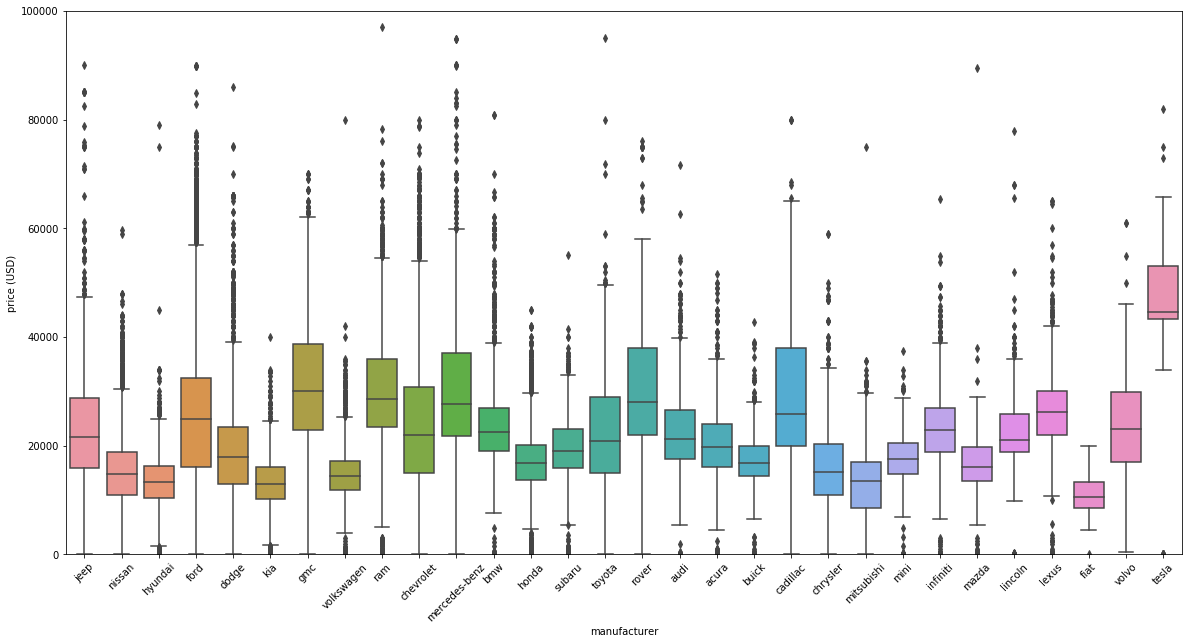

In [24]:
plot_correlation(trimmed_df, 'manufacturer', fig_size=(20,10))

In [25]:
cut_df = trimmed_df[trimmed_df['price'] <= 1e5]
cut_df = cut_df[cut_df['odometer'] <= 2e5]

cut_df.to_csv(os.path.join(data_dir, 'vehicles_cut.csv'), index=False)

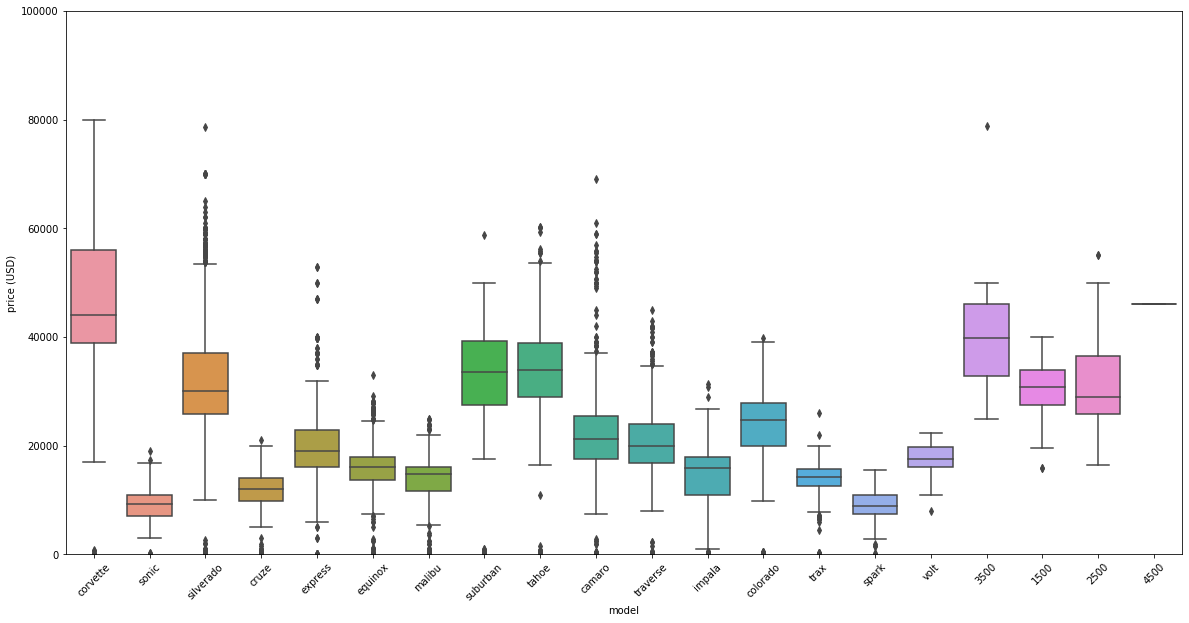

In [26]:
chevrolet_df = cut_df[cut_df['manufacturer'] == 'chevrolet']

plot_correlation(chevrolet_df, 'model', fig_size=(20,10))

(array([0, 1, 2, 3]), <a list of 4 Text xticklabel objects>)

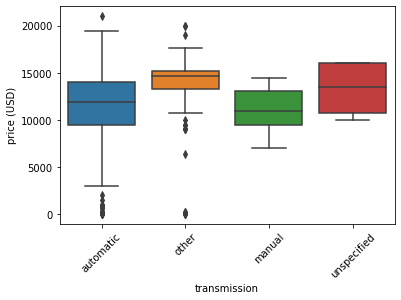

In [27]:
feature = 'transmission'

cruze_df = chevrolet_df[chevrolet_df['model'] == 'cruze']

sb.boxplot(data=cruze_df, x=feature, y='price')
plt.ylabel('price (USD)')
plt.xlabel(feature)
plt.xticks(rotation=45)

In [28]:
concat_df = cut_df.copy()

concat_df['model'] = concat_df['manufacturer'] + '-' + concat_df['model']

concat_df.drop(columns=['manufacturer'], inplace=True)

concat_df.to_csv(os.path.join(data_dir, 'vehicles_concat.csv'), index=False)

concat_df

,price,year,model,condition,cylinders,fuel,odometer,transmission,drive,size,type,paint_color
0,24895.0,2019.0,jeep-cherokee,unspecified,4 cylinders,gas,6973.0,automatic,4wd,unspecified,SUV,white
1,12999.0,2016.0,nissan-altima,unspecified,unspecified,gas,63810.0,unspecified,fwd,unspecified,sedan,unspecified
2,12799.0,2017.0,hyundai-elantra,unspecified,unspecified,gas,80210.0,automatic,unspecified,unspecified,sedan,silver
3,17850.0,2016.0,ford-f150,unspecified,6 cylinders,gas,76393.0,automatic,rwd,unspecified,unspecified,white
4,24150.0,2016.0,dodge-challenger,unspecified,unspecified,gas,74540.0,automatic,rwd,unspecified,coupe,white
...,...,...,...,...,...,...,...,...,...,...,...,...
117892,33064.0,2019.0,ram-1500,unspecified,unspecified,gas,42920.0,automatic,4wd,unspecified,unspecified,black
117893,27987.0,2018.0,toyota-tacoma,unspecified,unspecified,unspecified,44444.0,automatic,rwd,unspecified,unspecified,unspecified
117894,32663.0,2018.0,chevrolet-traverse,unspecified,unspecified,gas,18498.0,automatic,4wd,unspecified,SUV,silver
117895,22986.0,2019.0,chevrolet-equinox,unspecified,unspecified,gas,21598.0,automatic,4wd,unspecified,SUV,white


In [29]:
cruze_df = concat_df[concat_df['model'] == 'chevrolet-cruze']

cruze_df

,price,year,model,condition,cylinders,fuel,odometer,transmission,drive,size,type,paint_color
137,12900.0,2015.0,chevrolet-cruze,unspecified,4 cylinders,gas,62361.0,automatic,fwd,unspecified,sedan,blue
147,9895.0,2015.0,chevrolet-cruze,excellent,unspecified,gas,78351.0,automatic,fwd,unspecified,sedan,black
499,11995.0,2015.0,chevrolet-cruze,good,4 cylinders,gas,87345.0,automatic,rwd,compact,sedan,green
554,13000.0,2017.0,chevrolet-cruze,excellent,4 cylinders,gas,65000.0,automatic,fwd,unspecified,hatchback,blue
726,8777.0,2016.0,chevrolet-cruze,unspecified,unspecified,gas,65552.0,automatic,unspecified,compact,sedan,silver
...,...,...,...,...,...,...,...,...,...,...,...,...
115660,12499.0,2016.0,chevrolet-cruze,unspecified,unspecified,gas,48430.0,automatic,fwd,unspecified,sedan,grey
116748,13468.0,2018.0,chevrolet-cruze,unspecified,unspecified,unspecified,38665.0,automatic,fwd,unspecified,sedan,grey
116867,14925.0,2017.0,chevrolet-cruze,unspecified,4 cylinders,unspecified,23401.0,automatic,fwd,unspecified,sedan,custom
117635,8950.0,2016.0,chevrolet-cruze,unspecified,4 cylinders,unspecified,116819.0,automatic,fwd,unspecified,sedan,unspecified


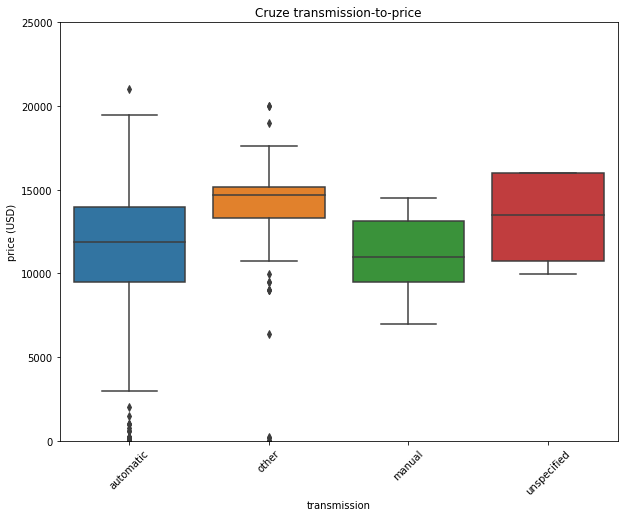

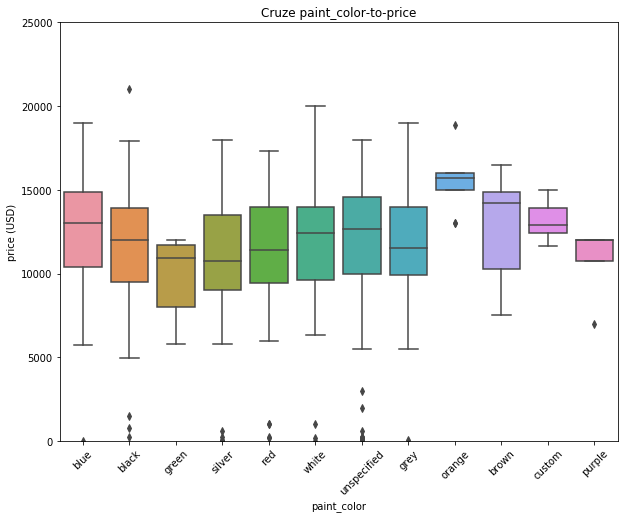

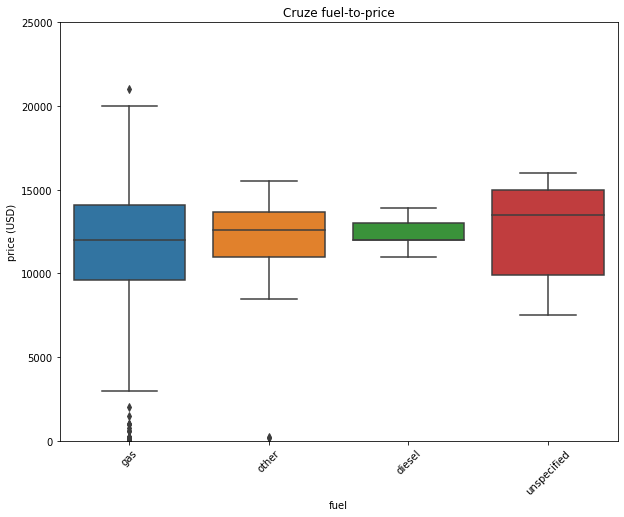

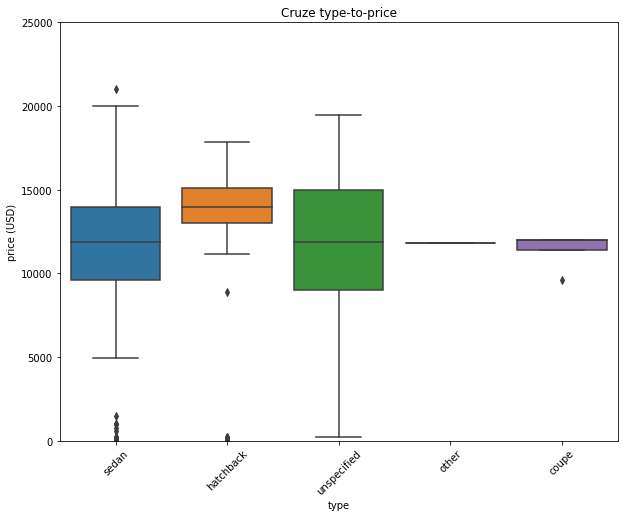

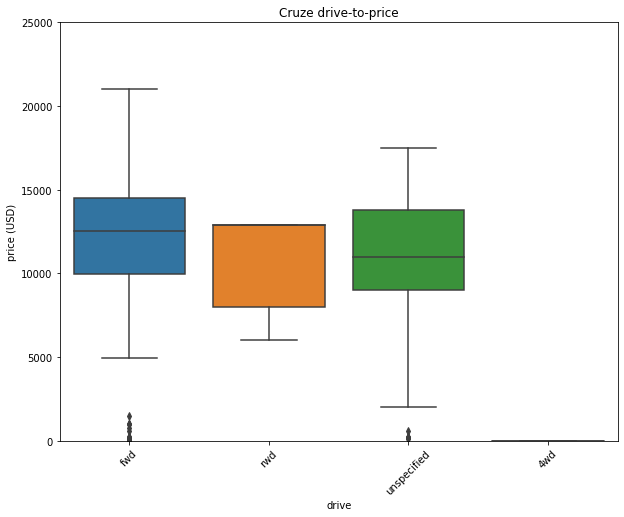

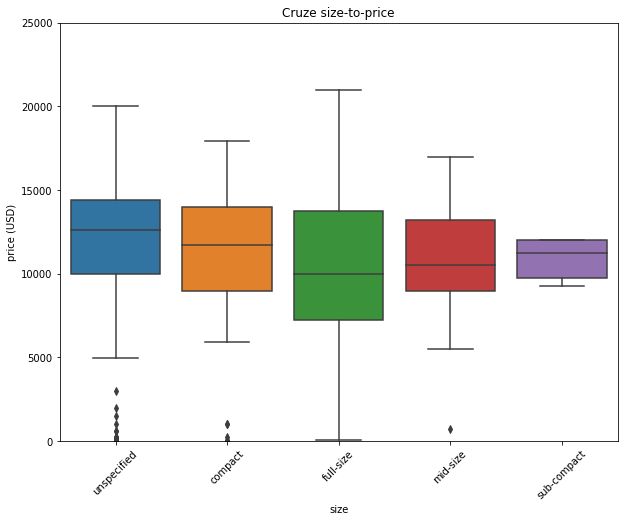

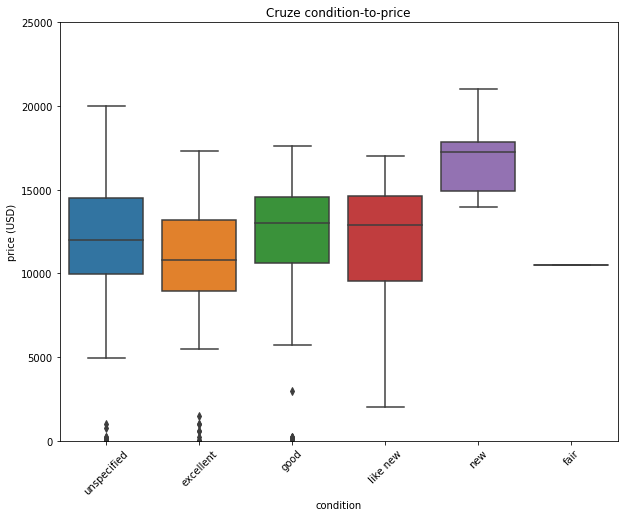

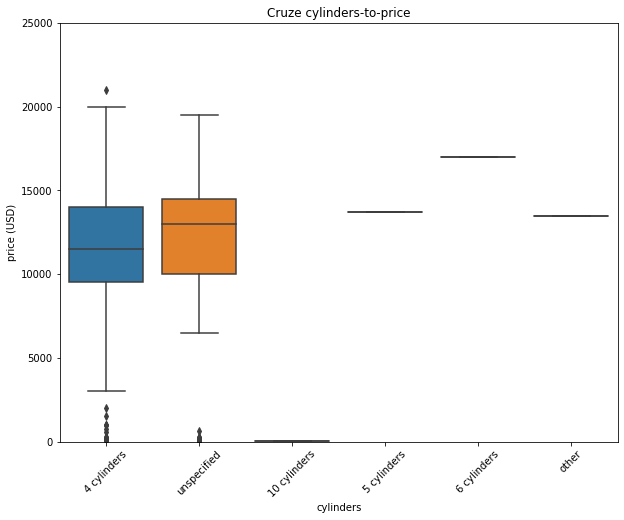

In [33]:
correlation_features = ['transmission', 'paint_color', 'fuel', 'type', 'drive', 'size', 'condition']

for feature in correlation_features:
    plot_correlation(cruze_df, feature, fig_size=(10, 7.7), ylim=(0, 25000))
    plt.title('Cruze {}-to-price'.format(feature))

Text(0.5, 1.0, 'Cruze odometer-to-price')

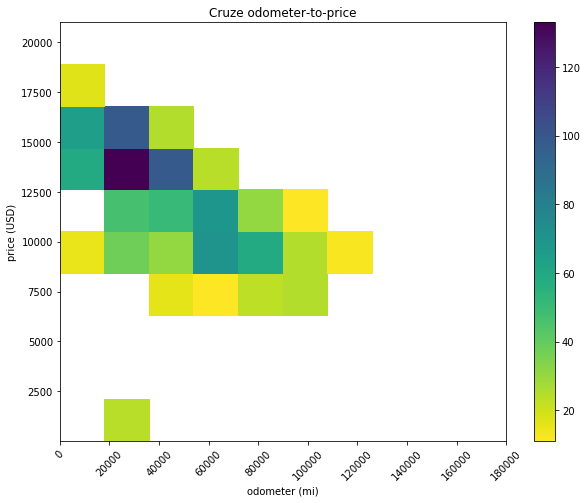

In [36]:
plt.figure(figsize=(10, 7.7))
plt.hist2d(data=cruze_df, x='odometer', y='price', cmap = 'viridis_r', cmin=10)
plt.colorbar();
plt.ylabel('price (USD)')
plt.xlabel('odometer (mi)')
plt.xticks(rotation=45)
plt.title('Cruze odometer-to-price')

## Categorical features distribution
Here we explore how balanced or imbalanced the distribution of our categorical features' classes are.

Features to be explored are:
1. model
2. manufacturer
3. transmission
4. paint_color
5. fuel
6. type
7. drive
8. size
9. type

In [13]:
import math

def plot_class_distribution(df, feature, fig_size=(6.4, 4.8), others_threshold=10, kind='bar'):
    counts = df[feature].value_counts(ascending=True)

    mask = counts[counts < others_threshold]
    others_count = mask.sum()

    if others_count > 0:
        counts = counts[counts >= others_threshold]
        counts = counts.sort_values(0)
        counts.loc['others'] = others_count

    plt.figure(figsize=fig_size)
    plt.ylabel(feature)
    plt.xlabel('count')
    plt.title('{} class distribution'.format(feature.capitalize()))

    counts.plot(kind=kind)

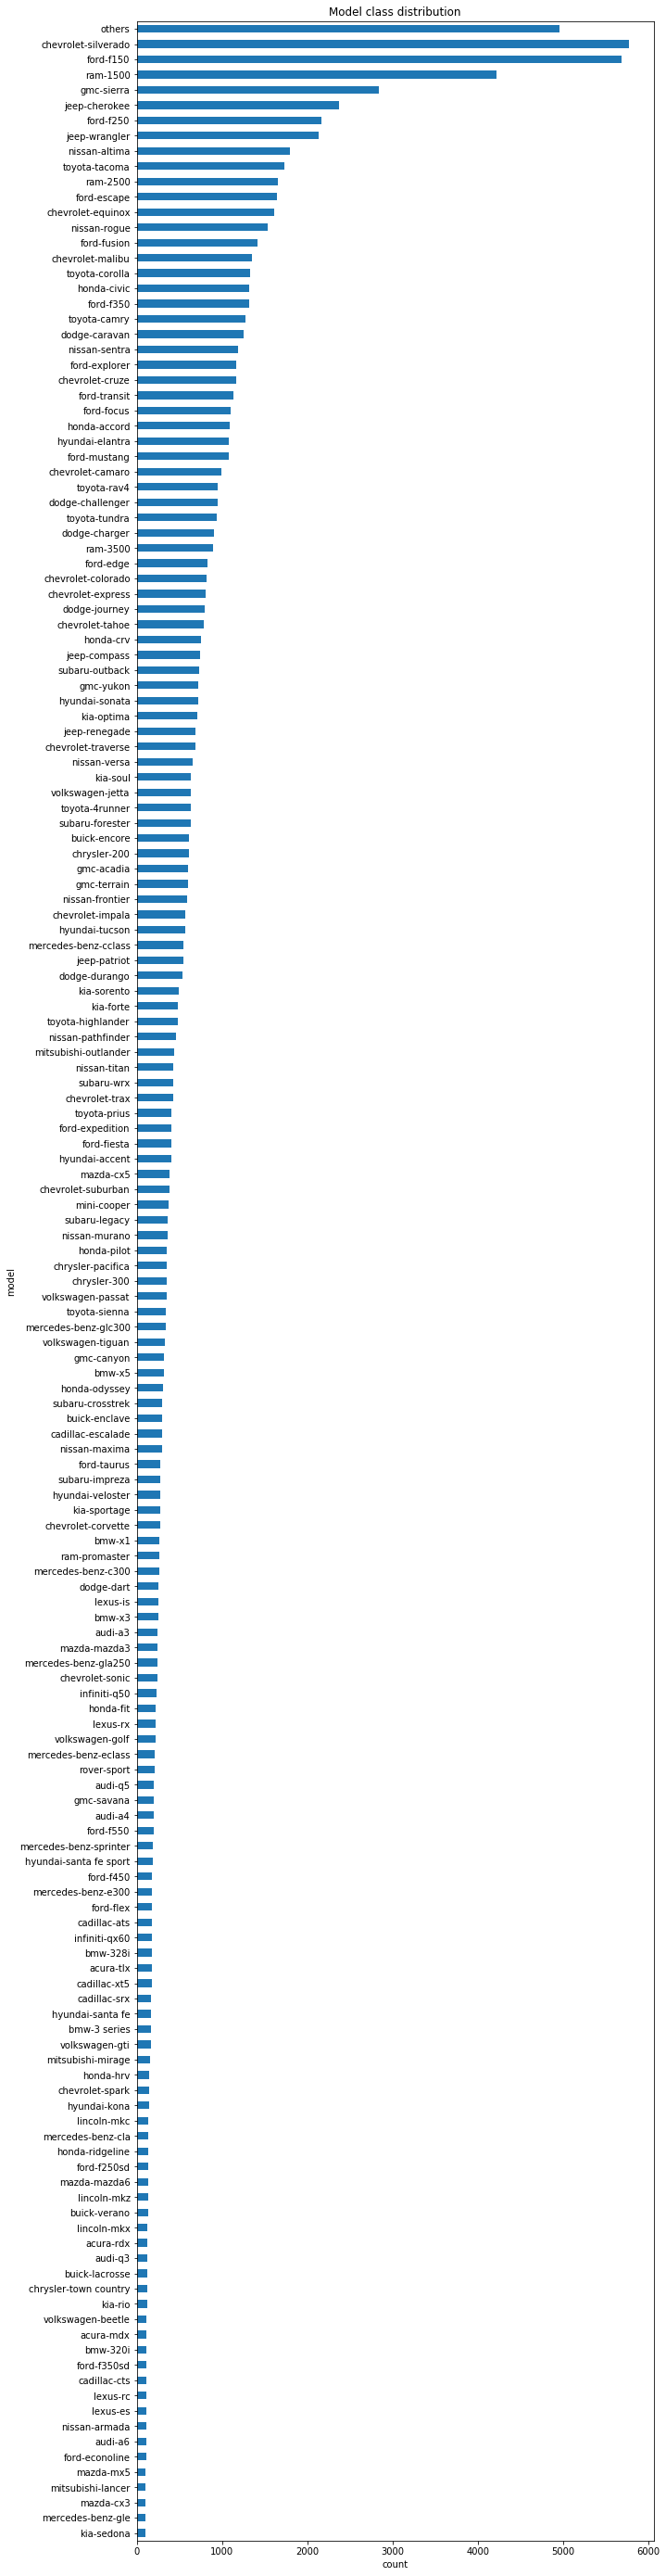

In [41]:
plot_class_distribution(concat_df, 'model', fig_size=(10, 50), others_threshold=100, kind='barh')

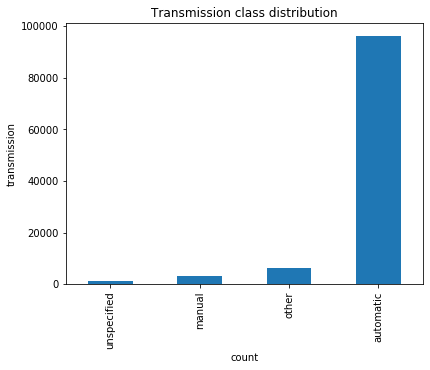

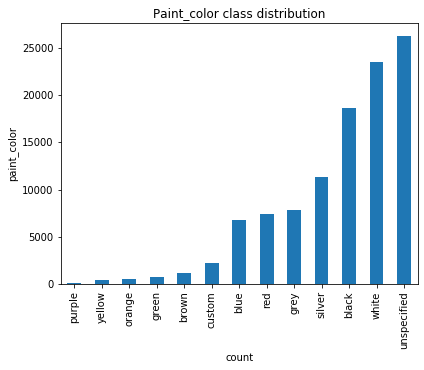

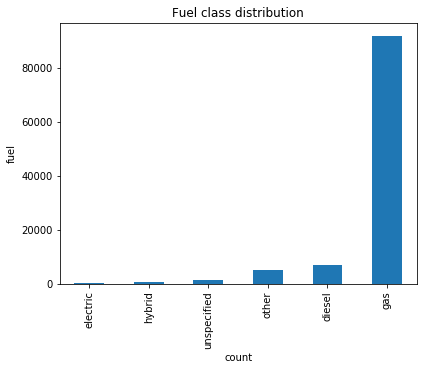

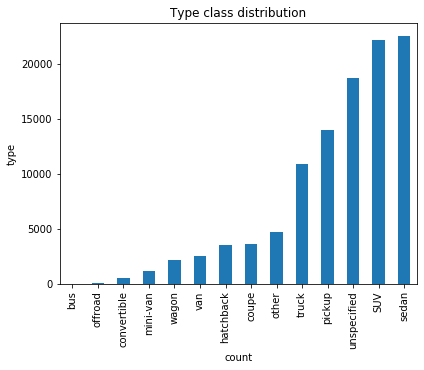

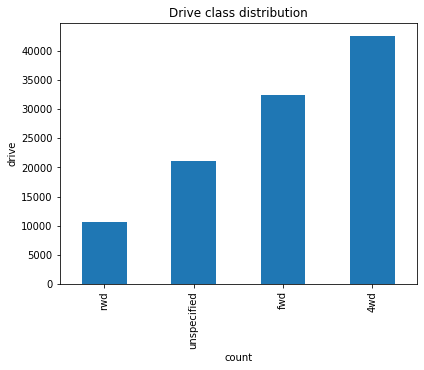

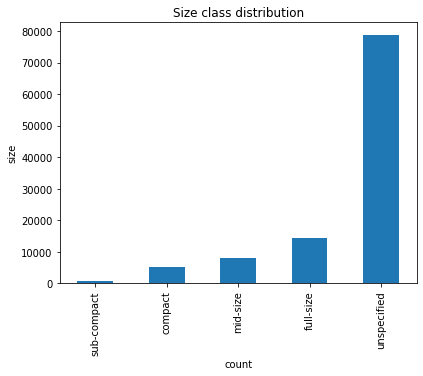

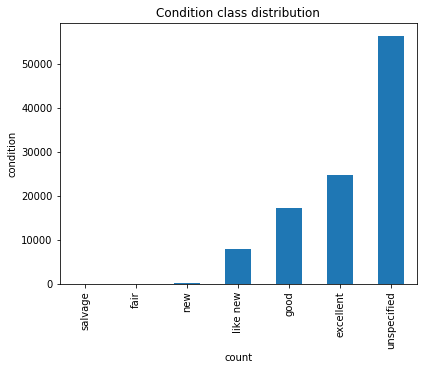

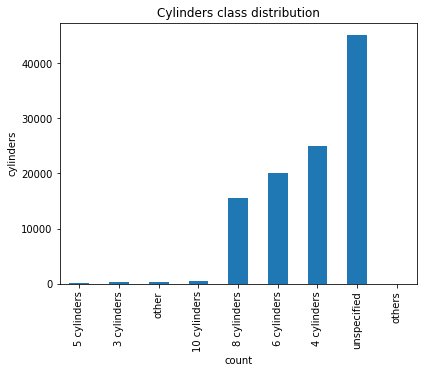

In [46]:
distribution_features = ['transmission', 'paint_color', 'fuel', 'type', 'drive', 'size', 'condition']

for feature in distribution_features:
    plot_class_distribution(concat_df, feature)